In [11]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision
import os
import random
import shutil

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import math
import torchvision.models as models

10000


In [12]:
csv_file_path = "/kaggle/input/data/Data_Entry_2017.csv"
df = pd.read_csv(csv_file_path, usecols=[0, 1], index_col = None)
print(df)
def find_lable(file_name):
    resulted_df = df[df.iloc[:, 0] == file_name]  # Assuming the file name is in the first column
    if not resulted_df.empty:
        return resulted_df.iloc[0, 1]  # Assuming the label is in the second column
    else:
        return "Label not found for file: {}".format(file_name)
    

             Image Index          Finding Labels
0       00000001_000.png            Cardiomegaly
1       00000001_001.png  Cardiomegaly|Emphysema
2       00000001_002.png   Cardiomegaly|Effusion
3       00000002_000.png              No Finding
4       00000003_000.png                  Hernia
...                  ...                     ...
112115  00030801_001.png          Mass|Pneumonia
112116  00030802_000.png              No Finding
112117  00030803_000.png              No Finding
112118  00030804_000.png              No Finding
112119  00030805_000.png              No Finding

[112120 rows x 2 columns]


In [14]:
def copy(src,dest,filename):
    os.makedirs(dest,exist_ok=True)
    input_path = os.path.join(src, filename)
    output_path = os.path.join(dest, filename)
    shutil.copyfile(input_path, output_path)

In [15]:
def processing():
    folders_to_loop = ["/kaggle/input/data/images_001/images","/kaggle/input/data/images_002/images", "/kaggle/input/data/images_002/images", "/kaggle/input/data/images_004/images"]
    os.makedirs("dataset", exist_ok = True)
    for i in folders_to_loop:
        for filename in os.listdir(i):
#             print(filename)
            lable = find_lable(filename)
            split_lables = lable.split('|')
            for x in split_lables:
                dest = "dataset/"+x
#                 print(dest)
                copy(i, dest, filename)
        
            
processing()

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

freeze = False
dropout = True
prob = 0.3
lr = 0.001
momentum = 0.9
step_size = 20
gamma = 0.1
criterion_name = 'Focal'
optimizer_name = 'Adam'
num_classes = 2
num_epochs = 30
batch_size = 30

In [17]:
transform = v2.Compose([
    v2.Resize(256),   #must same as here
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

path = "/kaggle/working/dataset"
dataset = torchvision.datasets.ImageFolder(root = path, transform = transform)
print(len(dataset))

30288


In [18]:
train_size = int(0.6 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
print('Train dataset size:', train_size)
print('Validate dataset size:', val_size)
print('Test dataset size:', test_size)
class_names = dataset.classes
print('Class names:', class_names)

Train dataset size: 18172
Validate dataset size: 4543
Test dataset size: 7573
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [27]:
train_count = len(train_data)
test_count = len(test_data)
val_count = len(val_data)
start_time = time.time()

labels tensor([11,  2, 14,  8,  8, 10,  8,  8,  8,  2, 14, 10])


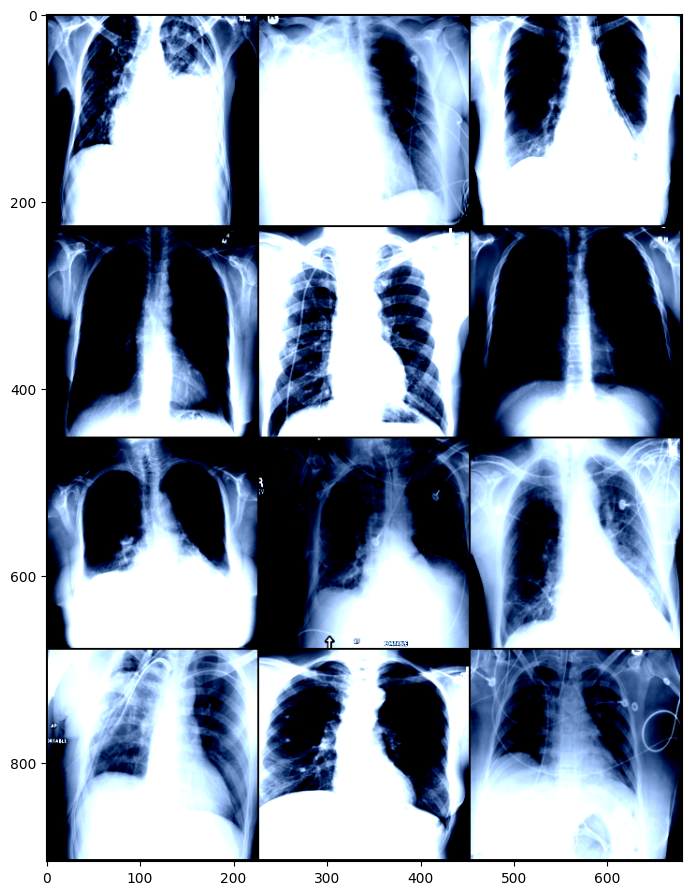

In [28]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 12,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)

show_transformed_images(train_data)

In [29]:
model = torchvision.models.resnet18(num_classes=15, weights=None)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [30]:
best_accuracy=0.0
train_accu_l = [0]
val_accu_l = [0]
val_loss_l = [0]
train_loss_l = [0]
batch_train_accu_l = [0]
batch_train_loss_l = [0]
for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total_batches = math.ceil(train_count/batch_size)
    batch = 0
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        images_count = len(images)
        batch_train_accuracy = 0
        batch_train_loss = 0
        optimizer.zero_grad()

        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()


        batch_train_loss+= int(loss.cpu().data*images.size(0))
        _,prediction=torch.max(outputs.data,1)

        batch_train_accuracy+=int(torch.sum(prediction==labels.data))*100
        train_accuracy+=batch_train_accuracy
        train_loss+=batch_train_loss
        batch_train_accuracy = batch_train_accuracy/images_count
        batch_train_loss = batch_train_loss/images_count
        images_count+=batch_size
        batch = batch+1;
        batch_train_accu_l.append(batch_train_accuracy)
        batch_train_loss_l.append(batch_train_loss)

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    model.eval()

    val_accuracy=0.0
    val_loss = 0.0
    for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        val_loss+= int(loss.cpu().data*images.size(0))
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))*100

    val_accuracy=val_accuracy/val_count
    val_loss=val_loss/val_count
    train_accu_l.append(train_accuracy)
    val_accu_l.append(val_accuracy)
    val_loss_l.append(val_loss)
    train_loss_l.append(train_loss)

    print('Epoch: '+str(epoch+1)+' | Training Loss: '+str(round(train_loss,4))+' | Training Accuracy: '+str(round(train_accuracy,2))+"% "+' | Validation Loss: '+str(round(val_loss,4))+' | Validation Accuracy: '+str(round(val_accuracy,2))+"%")

    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_15_ResNet.model')
        best_accuracy=val_accuracy

Epoch: 1 | Training Loss: 1.8663 | Training Accuracy: 47.42%  | Validation Loss: 1.9001 | Validation Accuracy: 48.82%
Epoch: 2 | Training Loss: 1.8082 | Training Accuracy: 47.65%  | Validation Loss: 1.8331 | Validation Accuracy: 48.87%
Epoch: 3 | Training Loss: 1.7795 | Training Accuracy: 47.87%  | Validation Loss: 1.6 | Validation Accuracy: 49.04%
Epoch: 4 | Training Loss: 1.7556 | Training Accuracy: 48.13%  | Validation Loss: 1.5333 | Validation Accuracy: 48.45%
Epoch: 5 | Training Loss: 1.7225 | Training Accuracy: 48.61%  | Validation Loss: 2.1666 | Validation Accuracy: 45.7%
Epoch: 6 | Training Loss: 1.6867 | Training Accuracy: 49.26%  | Validation Loss: 1.7999 | Validation Accuracy: 48.07%
Epoch: 7 | Training Loss: 1.6454 | Training Accuracy: 49.86%  | Validation Loss: 1.4 | Validation Accuracy: 48.01%
Epoch: 8 | Training Loss: 1.6012 | Training Accuracy: 50.85%  | Validation Loss: 1.4999 | Validation Accuracy: 44.42%
Epoch: 9 | Training Loss: 1.5511 | Training Accuracy: 52.26%  |

In [31]:
print(val_accu_l)
print(train_accu_l)

num_epochs = len(train_accu_l)

[0, 48.82236407660137, 48.866387849438695, 49.04248294078803, 48.448162007484044, 45.69667620515078, 48.07395993836672, 48.00792427911072, 44.41998679286815, 48.71230464450804, 46.797270526084084, 40.30376403257759, 46.51111600264143, 40.47985912392692, 46.92934184459608, 36.1435174994497, 36.49570768214836, 43.40744001760951, 29.561963460268544, 44.24389170151882, 42.26282192383887, 45.65265243231345, 36.64979088707902, 29.914153642967204, 43.12128549416685, 29.18776139115122, 36.95795729694035, 37.77239709443099, 39.70944309927361, 32.3794849218578, 37.508254457407]
[0, 47.42460928901607, 47.6502311248074, 47.87034998899406, 48.13449262601805, 48.60774818401937, 49.262601804974686, 49.85692273827867, 50.852960598723314, 52.256218357913276, 53.98415144177856, 55.767114241690514, 57.84173453664979, 60.516178736517716, 62.783403037640326, 65.0231124807396, 67.34536649790887, 70.17389390270746, 71.92383887299141, 73.80035219018269, 75.79793088267664, 77.34426590358794, 78.19722650231125,

In [32]:
y_true = []
y_pred = []
model.eval()
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))*100
    y_true.extend(labels.data.cpu().numpy())
    y_pred.extend(prediction.data.cpu().numpy())
final_test_accuracy = test_accuracy/test_count
print("Accuracy on Test Data with "+str(test_count)+" images is "+str(round(final_test_accuracy,2))+"%")

Accuracy on Test Data with 7573 images is 36.43%


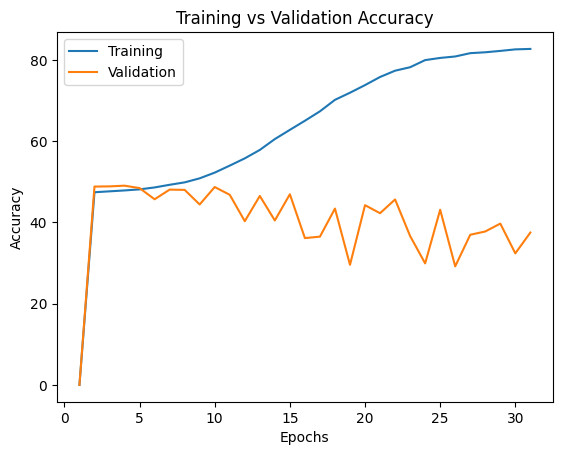

In [33]:
plt.plot(range(1, num_epochs + 1), train_accu_l, label="Training")
plt.plot(range(1, num_epochs + 1), val_accu_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

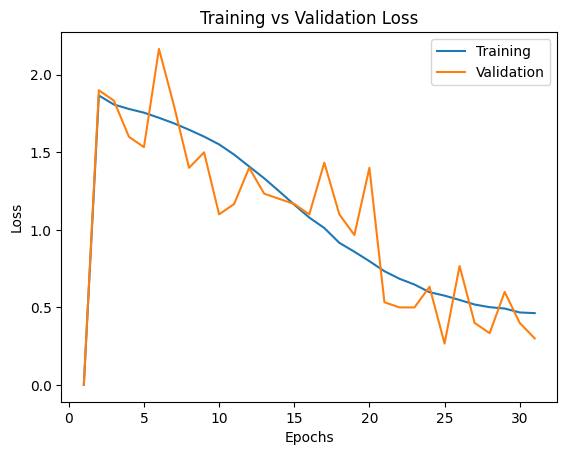

In [34]:
plt.plot(range(1,num_epochs+1),train_loss_l,label="Training")
plt.plot(range(1,num_epochs+1),val_loss_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

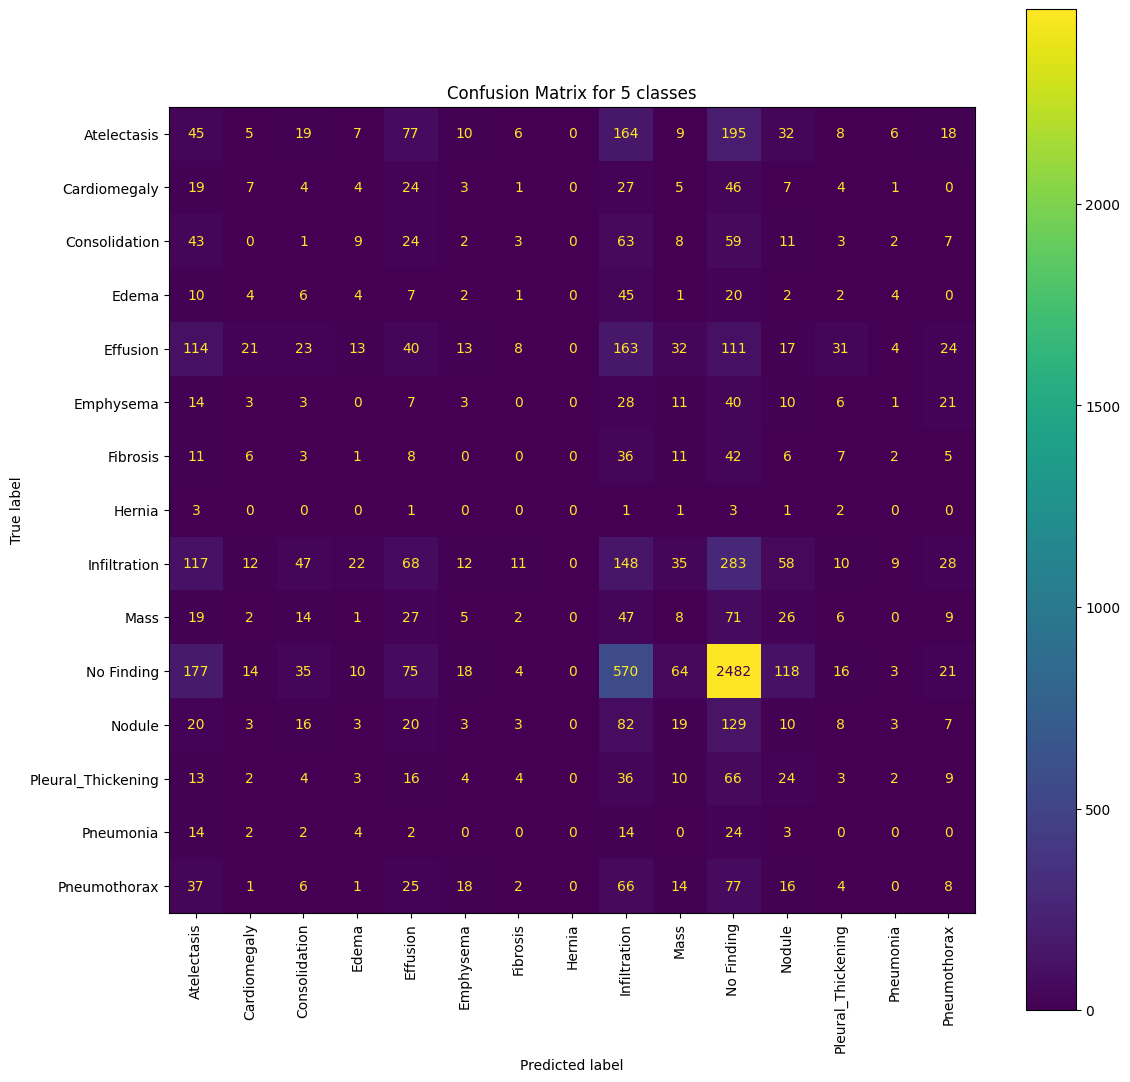

In [37]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix for 5 classes")
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [38]:
print("Accuracy on Test Data :"+str(final_test_accuracy))
print("Precision on Test Data :{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall on Test Data :{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score on Test Data :{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Accuracy on Test Data :36.43206127030239
Precision on Test Data :0.36
Recall on Test Data :0.36
F1-Score on Test Data :0.36


In [39]:
import pandas
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Accuracy": train_accu_l,"Validation Accuracy": val_accu_l})
df.to_csv("./accuracies_5_classes_ResNet.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Loss": train_loss_l,"Validation Loss": val_loss_l})
df.to_csv("./loss_5_classes_ResNet.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Y_true": y_true, "Y_pred": y_pred})
df.to_csv("./Y_values_5_classes_ResNet.csv", sep=',',index=False)